In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Flatten, Concatenate

In [2]:
np.random.seed(123)

In [82]:
# Params
n_stores = 3
n_days = 365
store_ids = [f"Store_{i}" for i in range(n_stores)]
time_depth = 21
split_date = pd.to_datetime("2022-10-01")
horizon = 7

In [4]:
data = []

for store in store_ids:
    base_sales = np.random.randint(80,120)
    seasonality = 10 * np.sin(np.linspace(0, 2 * np.pi, n_days))
    promo = np.random.binomial(1, 0.2, n_days)
    temp = 15 + 10 * np.sin(np.linspace(0,4 * np.pi, n_days)) + np.random.normal(0,2,n_days)
    noise = np.random.normal(0,5,n_days)
    sales = base_sales + seasonality + 5 * promo - 0.5 * temp + noise

    df_store = pd.DataFrame({
            "Date": pd.date_range("2022-01-01", periods=n_days),
            "Store_ID": store,
            "Sales" : sales,
            "Promo": promo,
            "Temperature": temp
    })

    data.append(df_store)

df = pd.concat(data).reset_index(drop=True)

In [5]:
df.sort_values(["Date","Store_ID"]).head()

,Date,Store_ID,Sales,Promo,Temperature
0,2022-01-01,Store_0,76.655651,0,16.044601
365,2022-01-01,Store_1,102.055465,1,13.943660
730,2022-01-01,Store_2,91.410729,0,13.189264
1,2022-01-02,Store_0,76.532664,0,11.331789
366,2022-01-02,Store_1,92.181945,1,9.456350


In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["Store_ID_encoded"] = le.fit_transform(df["Store_ID"])

df_train = df[df["Date"] < split_date].copy()
df_val = df[df["Date"] >= split_date].copy()

In [56]:
df.sort_values(["Store_ID","Date"]).head(30)

,Date,Store_ID,Sales,Promo,Temperature,Store_ID_encoded
0,2022-01-01,Store_0,76.655651,0,16.044601,0
1,2022-01-02,Store_0,76.532664,0,11.331789,0
2,2022-01-03,Store_0,77.475796,0,16.794821,0
3,2022-01-04,Store_0,80.720992,0,16.553905,0
4,2022-01-05,Store_0,74.302497,1,13.453833,0
5,2022-01-06,Store_0,70.005424,0,17.600077,0
6,2022-01-07,Store_0,69.933949,0,18.686621,0
7,2022-01-08,Store_0,82.066055,0,18.840843,0
8,2022-01-09,Store_0,73.751797,0,18.783032,0
9,2022-01-10,Store_0,87.511423,0,17.070255,0


In [83]:
def create_sequences(df, time_steps=14, time_horizon=1):
    """
    Génère des séquences temporelles à partir d’un DataFrame pour l'entraînement d’un modèle séquentiel.

    Cette fonction extrait, pour chaque magasin, des séquences glissantes de caractéristiques sur une fenêtre
    de `time_steps` jours, et associe à chaque séquence une valeur cible correspondant aux ventes à prédire
    à un horizon temporel donné (`time_horizon`). Elle encode également l'identifiant du magasin pour chaque séquence.

    Paramètres :
    ----------
    df : pandas.DataFrame
        DataFrame contenant les colonnes 'Store_ID', 'Store_ID_encoded', 'Date', 'Sales', 'Promo', 'Temperature'.
    time_steps : int, optionnel (par défaut = 14)
        Nombre de jours utilisés pour constituer chaque séquence d’entrée.
    time_horizon : int, optionnel (par défaut = 1)
        Horizon de prédiction : nombre de jours dans le futur pour lequel la prédiction est faite.
        Par exemple, `time_horizon=1` prédit les ventes du jour suivant, `time_horizon=7` prédit celles dans une semaine.

    Retours :
    -------
    sequences : np.ndarray
        Tableau de forme (n_samples, time_steps, n_features) contenant les séquences d’entrée.
    targets : np.ndarray
        Tableau de forme (n_samples,) contenant les valeurs de ventes à prédire à l’horizon spécifié.
    store_ids : np.ndarray
        Tableau de forme (n_samples,) contenant l’identifiant encodé du magasin pour chaque séquence.
    """
    sequences = []
    targets = []
    store_ids = []
    th = time_horizon - 1
    
    for store_id in df["Store_ID"].unique():
        df_store = df[df["Store_ID"]==store_id].sort_values("Date")
        features = df_store[["Sales", "Promo", "Temperature"]].values
        store_encoded = df_store["Store_ID_encoded"].values[0]

        for i in range(len(features) - time_steps - th):
            seq = features[i:i+time_steps]
            target = features[i+time_steps+th][0] # Sales at t+time_horizon
            sequences.append(seq)
            targets.append(target)
            store_ids.append(store_encoded)
            
    return np.array(sequences), np.array(targets), np.array(store_ids)

X_train, y_train, store_ids_train = create_sequences(df_train,time_depth,horizon)
X_val, y_val, store_ids_val = create_sequences(df_val,time_depth,horizon)

In [85]:
y_train[0]

np.float64(71.47483194557068)

In [84]:
X_train[0]

array([[76.65565122,  0.        , 16.04460071],
       [76.53266427,  0.        , 11.33178881],
       [77.47579607,  0.        , 16.79482141],
       [80.72099172,  0.        , 16.55390466],
       [74.30249653,  1.        , 13.4538328 ],
       [70.00542429,  0.        , 17.60007717],
       [69.9339485 ,  0.        , 18.68662088],
       [82.06605465,  0.        , 18.8408434 ],
       [73.75179703,  0.        , 18.7830318 ],
       [87.5114233 ,  0.        , 17.07025513],
       [69.31000806,  0.        , 21.38812409],
       [76.30795309,  0.        , 18.33039855],
       [75.56211026,  0.        , 17.54504931],
       [69.91168811,  0.        , 17.01778003],
       [78.19503508,  0.        , 19.91028981],
       [63.03559513,  0.        , 20.70634451],
       [69.21275365,  0.        , 21.70340249],
       [76.32453249,  0.        , 22.64741892],
       [77.80276482,  0.        , 20.53721786],
       [93.29956973,  1.        , 18.22757728],
       [77.59540158,  0.        , 22.522

In [15]:
# # Entrées
# seq_input = Input(shape=(X_train.shape[1], X_train.shape[2])) # (21,3)
# store_input = Input(shape=(1,))

# # Embedding magasin
# store_embedding = Embedding(input_dim=n_stores, output_dim=4)(store_input)
# store_embedding_flat = Flatten()(store_embedding)

# # LSTM
# x = LSTM(64)(seq_input)

# # Fusion
# x = Concatenate()([x, store_embedding_flat])
# output = Dense(1)(x)

# model = Model(inputs=[seq_input, store_input], outputs=output)
# model.compile(optimizer="adam", loss="mse")

In [86]:
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model

# Entrées
seq_input = Input(shape=(X_train.shape[1], X_train.shape[2]))  # Array descriptifs(21, 3) des 21 pas 
                                                               # de temps précédents sur 3 variables
store_input = Input(shape=(1,)) # Entrée représentant l’identifiant du magasin

# Embedding magasin
store_embedding = Embedding(input_dim=n_stores, output_dim=4)(store_input) # Transforme chaque identifiant de magasin en un vecteur dense de taille 4. 
                                                                           # Cela permet au modèle d’apprendre une représentation vectorielle de chaque magasin.
store_embedding_flat = Flatten()(store_embedding)

# Bloc LSTM enrichi
x = LSTM(128, return_sequences=True)(seq_input) # return_sequences=True : 
                                                # renvoie toute la séquence de sorties (une sortie par
                                                # pas de temps), et pas seulement la dernière.
x = BatchNormalization()(x) # Normalise les activations de la couche précédente pour chaque mini-lot.
x = Dropout(0.2)(x) # régularisation qui consiste à désactiver aléatoirement 20% des neurones

x = LSTM(64)(x) # deuxième couche
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

# Fusion LSTM (comportement temporel) avec l'embedding magasin (comportement local)
x = Concatenate()([x, store_embedding_flat])

# Couche dense finale
output = Dense(1)(x)

# Modèle
model = Model(inputs=[seq_input, store_input], outputs=output)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])


In [87]:
x

<KerasTensor shape=(None, 68), dtype=float32, sparse=False, ragged=False, name=keras_tensor_65>

In [88]:
output

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_66>

In [89]:
model

<Functional name=functional_5, built=True>

In [90]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='loss',     # Surveille la perte sur le jeu de validation
    patience=20,            # Arrête l'entraînement si aucune amélioration pendant 20 epochs
    restore_best_weights=True  # Restaure les poids du meilleur modèle
)

model.fit(
    [X_train, store_ids_train],
    y_train,
    epochs=250,
    batch_size=32,
    validation_data=([X_val, store_ids_val], y_val),
    callbacks=[early_stop]
)

Epoch 1/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - loss: 7498.1113 - mae: 86.1118 - val_loss: 6927.0469 - val_mae: 82.7615
Epoch 2/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 7399.9634 - mae: 85.6862 - val_loss: 6843.4448 - val_mae: 82.2642
Epoch 3/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 7331.9282 - mae: 85.3149 - val_loss: 6847.0513 - val_mae: 82.3004
Epoch 4/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 7231.5176 - mae: 84.7548 - val_loss: 6860.0107 - val_mae: 82.4008
Epoch 5/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 7128.3501 - mae: 84.1449 - val_loss: 6800.9819 - val_mae: 82.0636
Epoch 6/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 6999.3745 - mae: 83.3808 - val_loss: 6595.6064 - val_mae: 80.8285
Epoch 7/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 6836.4194 - mae: 82.4073 - val_loss: 6568.7007 - val_mae: 80.6710
Epoch 8/250
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 6679.4722 - mae: 81.4466 - val_loss: 6427.0312 - val_mae:

In [46]:
# model.fit([X_train, store_ids_train], y_train, epochs=250, batch_size=32)

In [91]:
y_pred = model.predict([X_val, store_ids_val])

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


In [92]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_val, y_pred)
rmse = mean_squared_error(y_val, y_pred)

print(f"MAE : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")


MAE : 4.75
RMSE : 36.10


In [93]:
y_val.shape

(195,)

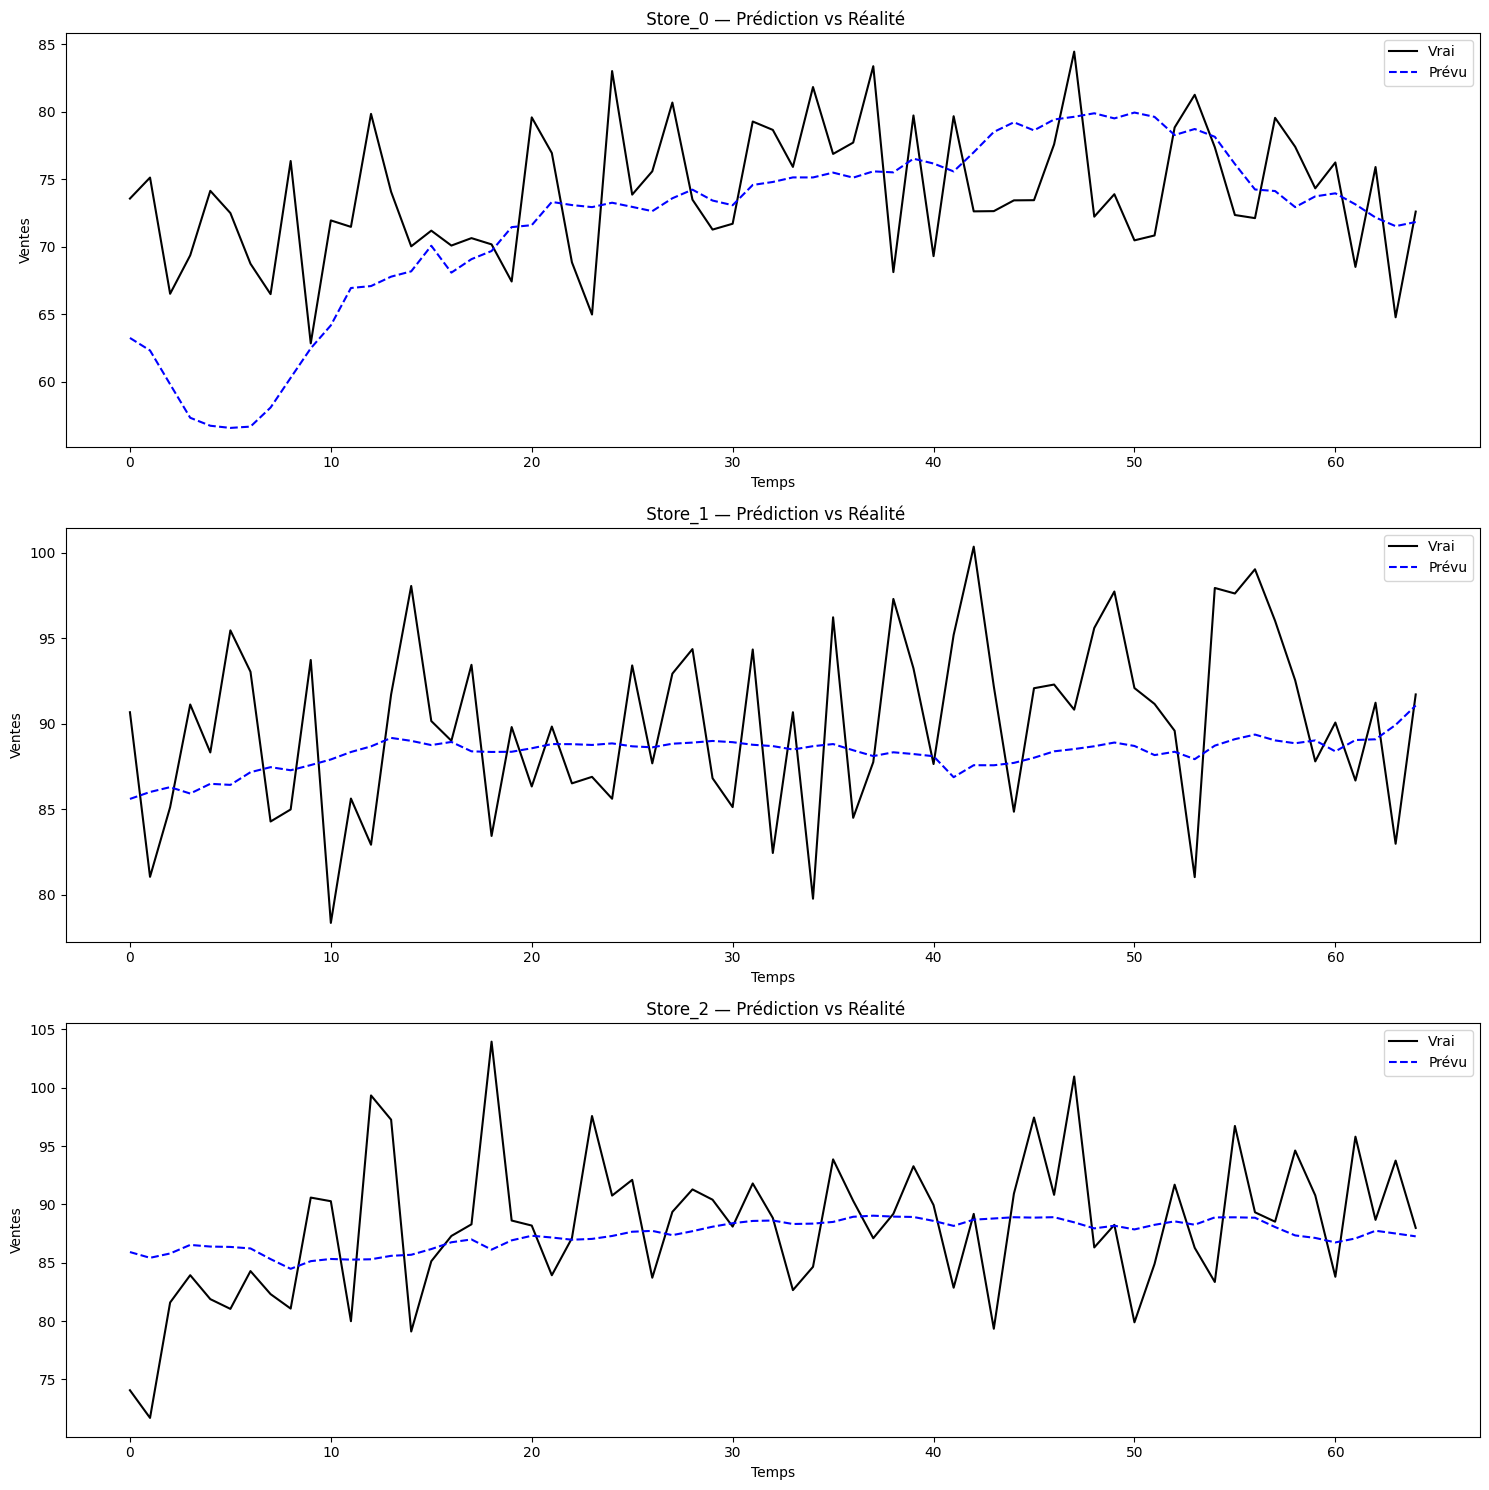

In [94]:
import matplotlib.pyplot as plt

# Récupérer les identifiants encodés
store_names = df["Store_ID"].unique()
store_encoded_map = dict(zip(le.transform(store_names), store_names))

# Tracer les courbes
plt.figure(figsize=(15, 5 * len(store_names)))

for i, store_code in enumerate(np.unique(store_ids_val)):
    # Filtrer les prédictions et vraies valeurs pour ce magasin
    idx = store_ids_val == store_code
    y_true_store = y_val[idx]
    y_pred_store = y_pred[idx].flatten()
    
    # Tracer
    plt.subplot(len(store_names), 1, i + 1)
    plt.plot(y_true_store, label="Vrai", color="black")
    plt.plot(y_pred_store, label="Prévu", color="blue", linestyle="--")
    plt.title(f" {store_encoded_map[store_code]} — Prédiction vs Réalité")
    plt.xlabel("Temps")
    plt.ylabel("Ventes")
    plt.legend()

plt.tight_layout()
plt.show()